# NGC2264

In [1]:
import aplpy
from astropy.io import fits
%pylab inline
plt.style.use(['dark_background'])

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rc('font', **{'family': 'serif', 'size': 20})
plt.rc('lines', linewidth = 2.5)
plt.rc('text', usetex=True)

INFO: Auto-setting vmin to  1.315e+21 [aplpy.core]
INFO: Auto-setting vmax to  5.158e+22 [aplpy.core]


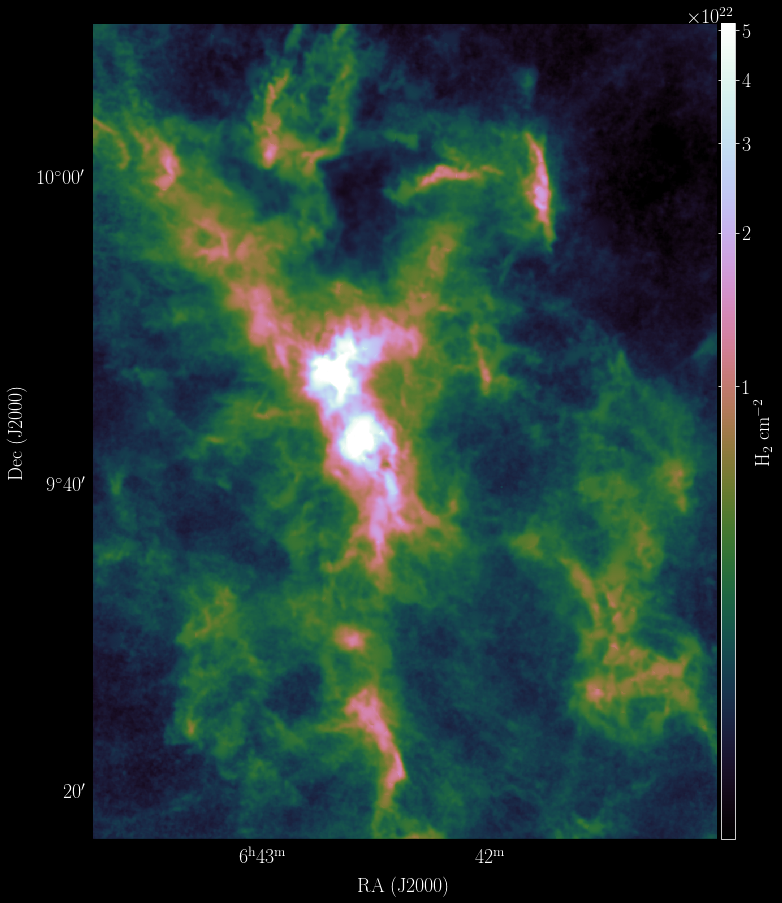

In [7]:
fig_all = plt.figure(1, figsize=(15,15))
figfile = '/Users/robitaij/postdoc/Herschel/NGC2264/new/hires.02.surfden.r18p2as.srcsub.cut.fits'
fig = aplpy.FITSFigure(figfile,figure=fig_all)
fig.show_colorscale(cmap='cubehelix',stretch='log',vmid=1e2)
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [8]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

HDU2 = fits.open('/Users/robitaij/postdoc/Herschel/NGC2264/new/hires.02.surfden.r18p2as.fits')
im2 = HDU2[0].data

In [9]:
from pywavan import fan_trans, apodize, padding, depad, powspec, gauss_beam

## Fourier Power Spectrum

Comparison between the original column density map and the subtracted source map (plotted above).

7.093391373169747


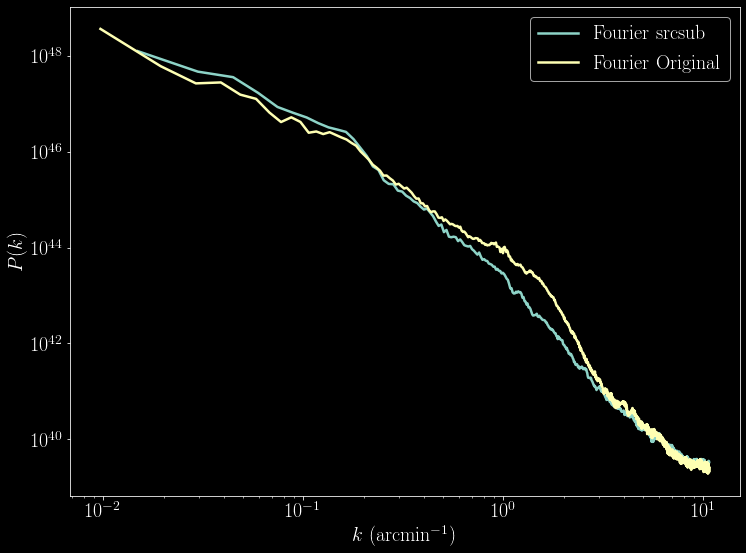

In [11]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

na = im.shape[1]
nb = im.shape[0]
imzm = im - np.mean(im)

#Apodization

newdim = np.array((1800,1800))
tapper = apodize(nb,na,0.98)
imt = imzm *tapper
imr = padding(imt,newdim[0],newdim[1])

#Fourier power spectrum
tab_k, spec_k = powspec(im, reso=reso)
tab_korig, spec_korig = powspec(im2, reso=reso)

noise = spec_k[477]
print(tab_k[477])

#Plot Fourier power spectrum
figure(figsize=(12,9))
plot(tab_k,spec_k, label="Fourier srcsub")
plot(tab_korig,spec_korig, label="Fourier Original")
xscale('log')
yscale('log')
xlabel(r"$k$ (arcmin$^{-1}$)")
ylabel(r"$P(k)$")
legend()

## Run MnGSeg

In [55]:
#Set a list of q
q=[]
q=[2.2]*26

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(im, reso=reso, q=q, qdyn=True, skewl=0.4, apodize= 0.98, arrdim = newdim, smooth=True)
#print q

1800 1800


In [67]:
np.save('/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264_wt.npy',wt)
np.save('/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264_S11a.npy',S11a)
np.save('/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264_wav_k.npy',wav_k)
np.save('/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264_S1a.npy',S1a)
np.save('/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264_q.npy',q)

_q_ is the free parameter for the non-Gaussian segmentation. The smaller is _q_, the more sensitive the algorithm is to non-Gaussiannities. It corresponds to _q_ times the standard deviation of the map at a given orientation and spatial scale.

The **qdyn** keyword means that once the once the converge to the optimal threshold for the non-Gaussian segmentation, the skewness of a the coefficient distribution is calculated. If the the skewness is greater than the value given to 'skewl' then the _q_ value is lowered and the optimal threshold is calculated again.

The **smooth=True** keyword applies a smoothing to every scales before the image reconstruction to avoid any discontinuity associated to the non-Gaussianities thresholding.

## Image Reconstruction

In [56]:
M = wav_k.shape[0]

coherent = np.sum(wt[M:2*M,:,:],axis=0)
Gaussian = np.sum(wt[2*M:3*M,:,:],axis=0)

fits.writeto('/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264_cohe.fits',\
            coherent.real,header,overwrite=True)
fits.writeto('/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264_gaussian.fits',\
            Gaussian.real,header,overwrite=True)

INFO: Auto-setting vmin to -3.989e+21 [aplpy.core]
INFO: Auto-setting vmax to  1.248e+22 [aplpy.core]
INFO: Auto-setting vmin to -1.146e+22 [aplpy.core]
INFO: Auto-setting vmax to  3.770e+22 [aplpy.core]


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

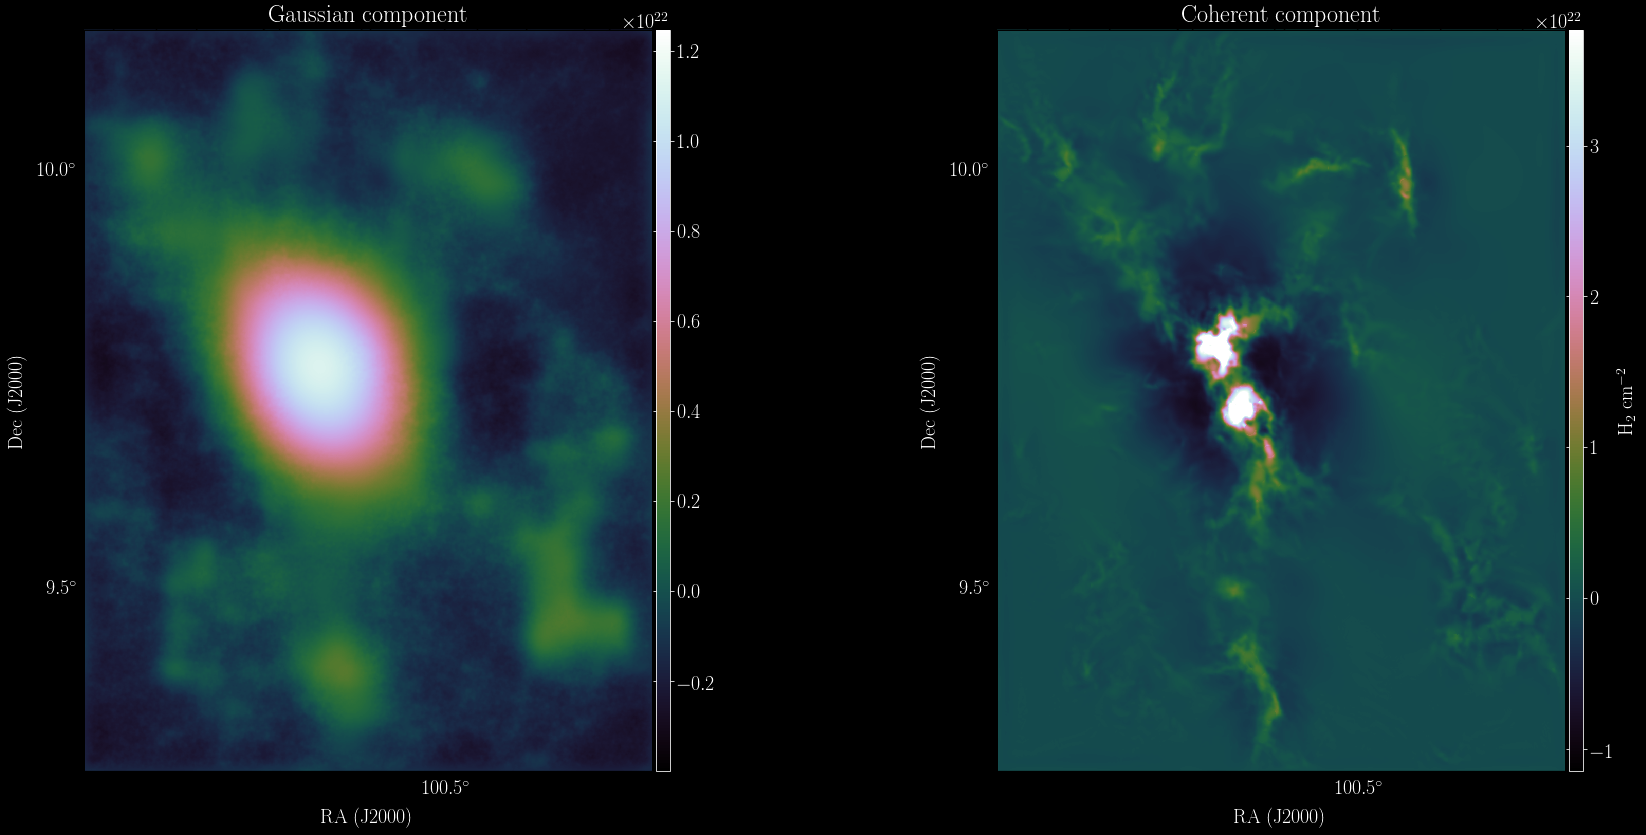

In [60]:
fig_all = plt.figure(1, figsize=(30,30))

figfile = '/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264_gaussian.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 1))
fig.show_colorscale(cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.set_title('Gaussian component')

figfile = '/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264_cohe.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 2))
fig.show_colorscale(cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
fig.set_title('Coherent component')

plt.tight_layout

The Gaussian component is dominated by a large scale point source not recognised as a non-Gaussiannity by the algorithm.

## Segmented power spectra

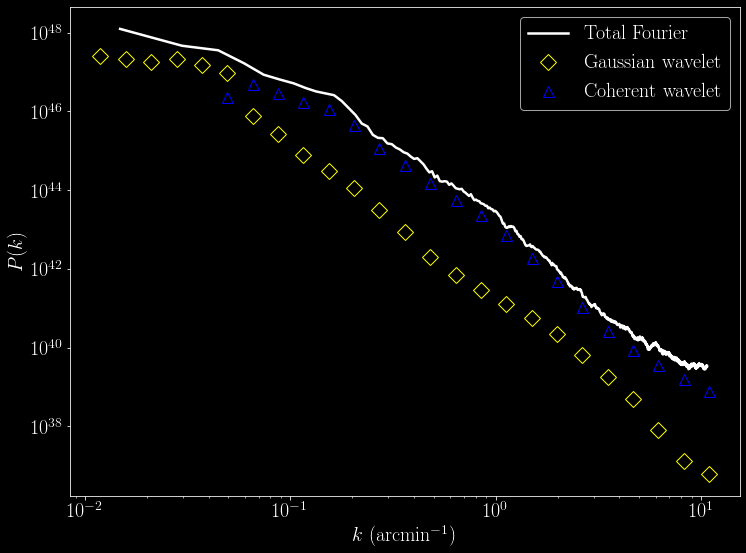

In [61]:
plt.figure(figsize(12,9))
plt.plot(tab_k, spec_k, color='white',label=r'Total Fourier')
plt.plot(wav_k[:-1], S1a[2,:-1],'D', markersize = 11, markerfacecolor='none', markeredgecolor='yellow', label='Gaussian wavelet')
plt.plot(wav_k[:-1], S1a[1,:-1],'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Coherent wavelet')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

According to the segmented power spectra, the non-Gaussian component is dominating in terms power at almost every scales except the larger scales. If we reconstruct the first five largest scales...

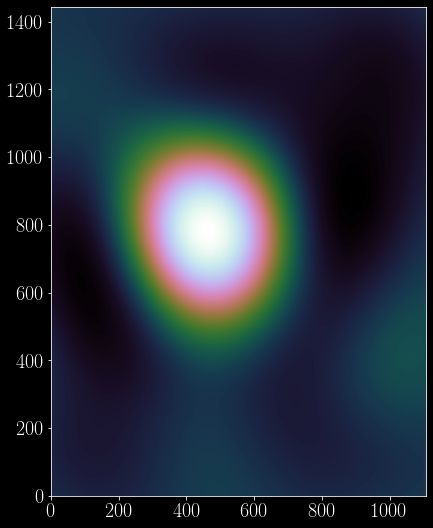

In [69]:
largscl = np.sum(wt[0:5,:,:],axis=0)

plt.figure(figsize(12,9))
imshow(largscl.real, origin='below', cmap='cubehelix')

It corresponds basically to the large scale point source present in the Gaussian part.

## Optimised _q_ parameter

We can look at the optimized _q_ parameter and see at which scales the algorithm did not recognised the non-Gaussianities

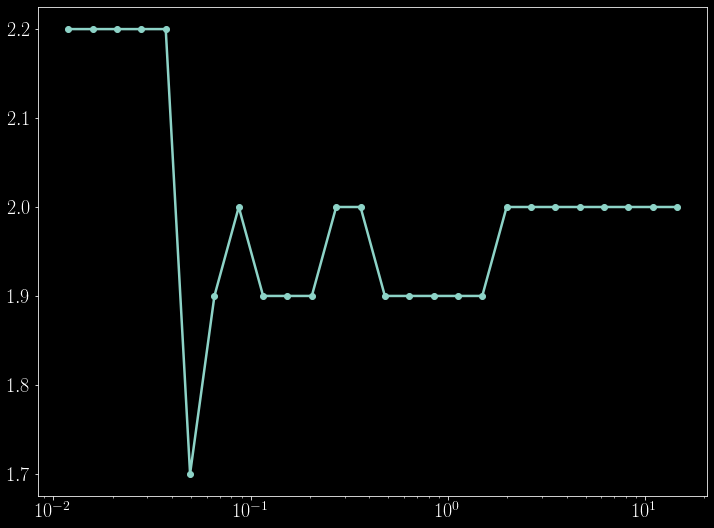

In [62]:
plot(wav_k,q,marker='o')
xscale('log')

The algorithm did not optimised _q_ for the first five scales, which means that it did not succeed to detect the obvious non-Gaussianites.

Let's look at the results of segmentation at smaller scales.

<BarContainer object of 24 artists>

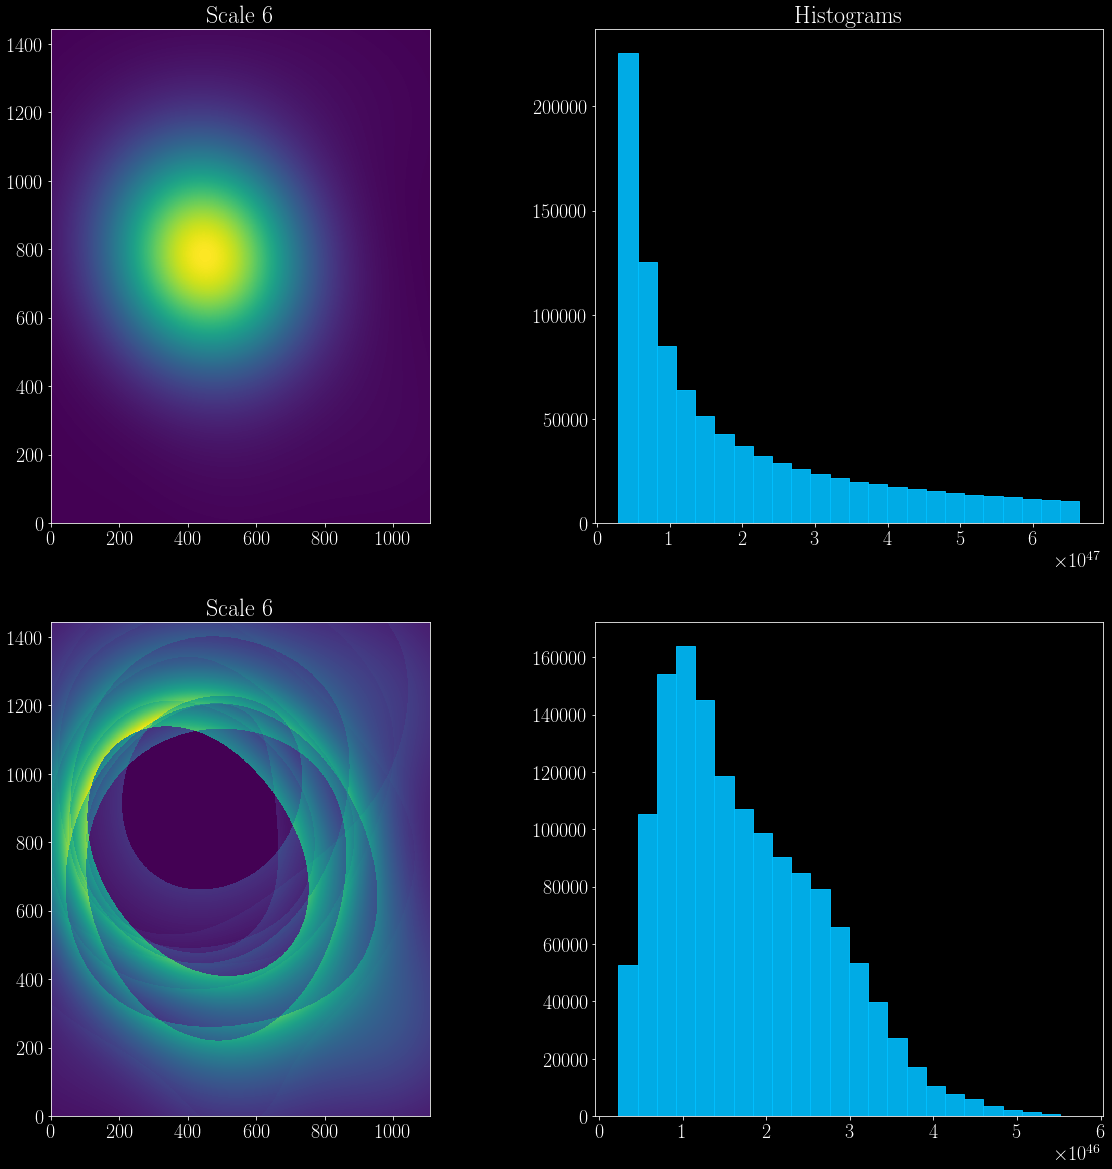

In [76]:
scale = 6

nbins = 25
histo, edges = np.histogram(S11a[scale,:,:], bins=nbins)
histoG, edgesG = np.histogram(S11a[2*M+scale,:,:], bins=nbins)

figure(figsize=(20,20))
subplot(2,2,1)
imshow(S11a[scale,:,:],origin='below')
title('Scale '+np.str(scale))

subplot(2,2,2)
bar(edges[1:-1], histo[1:], width=np.diff(edges[1:]), align="edge",\
        edgecolor='#00BFFF',facecolor='#00BFFF',alpha=0.9,\
        label= r'fBm')
title('Histograms')

subplot(2,2,3)
imshow(S11a[2*M+scale,:,:],origin='below')
title('Scale '+np.str(scale))

subplot(2,2,4)
bar(edgesG[1:-1], histoG[1:], width=np.diff(edgesG[1:]), align="edge",\
        edgecolor='#00BFFF',facecolor='#00BFFF',alpha=0.9,\
        label= r'fBm')

<BarContainer object of 24 artists>

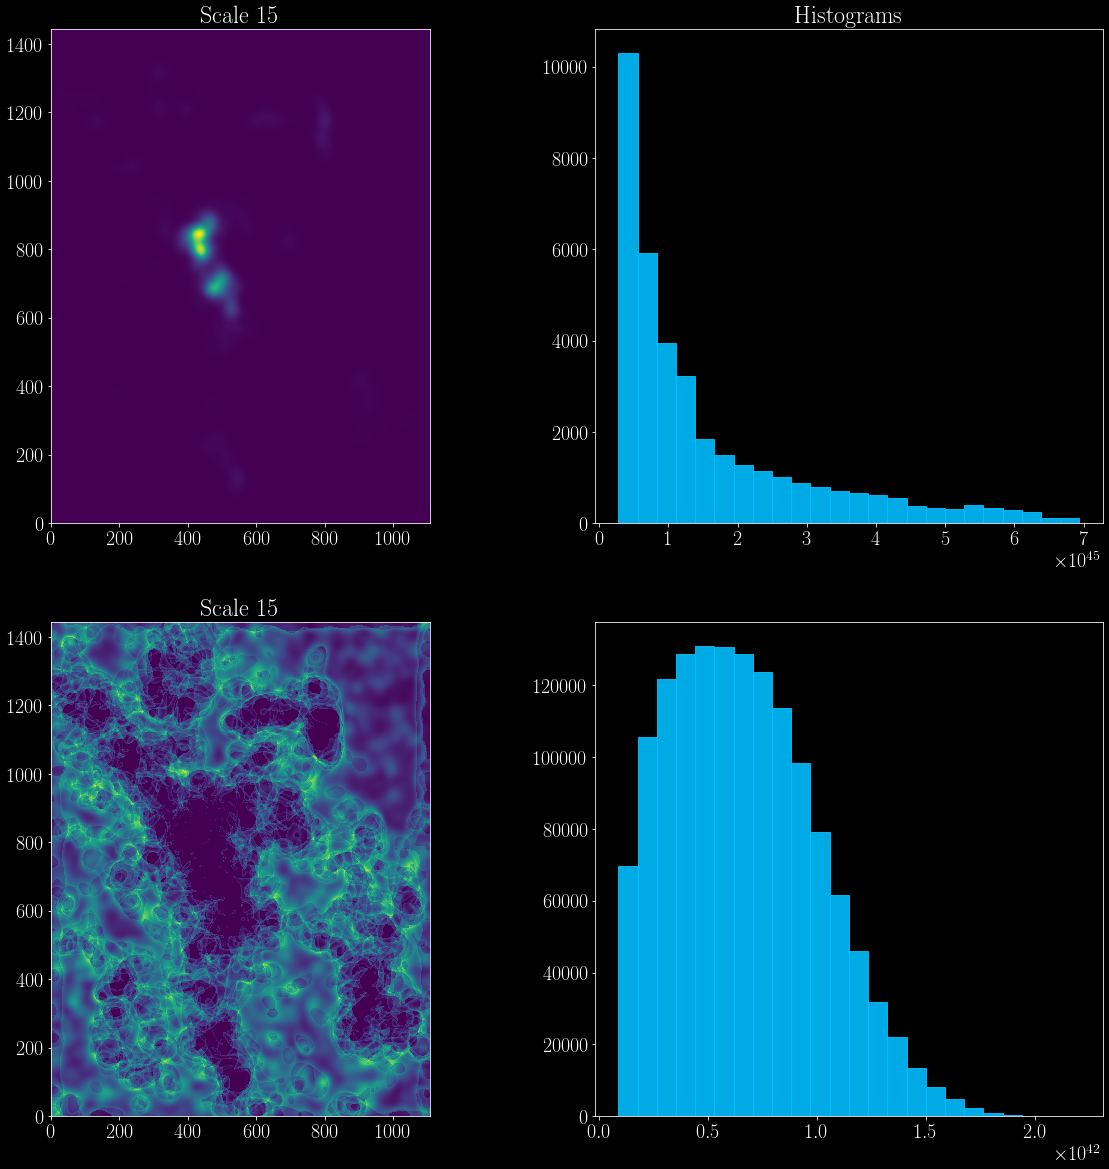

In [79]:
scale = 15

nbins = 25
histo, edges = np.histogram(S11a[scale,:,:], bins=nbins)
histoG, edgesG = np.histogram(S11a[2*M+scale,:,:], bins=nbins)

figure(figsize=(20,20))
subplot(2,2,1)
imshow(S11a[scale,:,:],origin='below')
title('Scale '+np.str(scale))

subplot(2,2,2)
bar(edges[1:-1], histo[1:], width=np.diff(edges[1:]), align="edge",\
        edgecolor='#00BFFF',facecolor='#00BFFF',alpha=0.9,\
        label= r'fBm')
title('Histograms')

subplot(2,2,3)
imshow(S11a[2*M+scale,:,:],origin='below')
title('Scale '+np.str(scale))

subplot(2,2,4)
bar(edgesG[1:-1], histoG[1:], width=np.diff(edgesG[1:]), align="edge",\
        edgecolor='#00BFFF',facecolor='#00BFFF',alpha=0.9,\
        label= r'fBm')

## Second reconstruction
Let's now define the first five largest scales as non-Gaussian.

In [70]:
M = wav_k.shape[0]

coherent = np.sum(wt[M+6:2*M,:,:],axis=0) + np.sum(wt[0:6,:,:],axis=0)
Gaussian = np.sum(wt[2*M+6:3*M,:,:],axis=0)

fits.writeto('/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264_coheB.fits',\
            coherent.real,header,overwrite=True)
fits.writeto('/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264_gaussianB.fits',\
            Gaussian.real,header,overwrite=True)

INFO: Auto-setting vmin to -1.901e+21 [aplpy.core]
INFO: Auto-setting vmax to  2.356e+21 [aplpy.core]
INFO: Auto-setting vmin to -7.841e+21 [aplpy.core]
INFO: Auto-setting vmax to  5.254e+22 [aplpy.core]


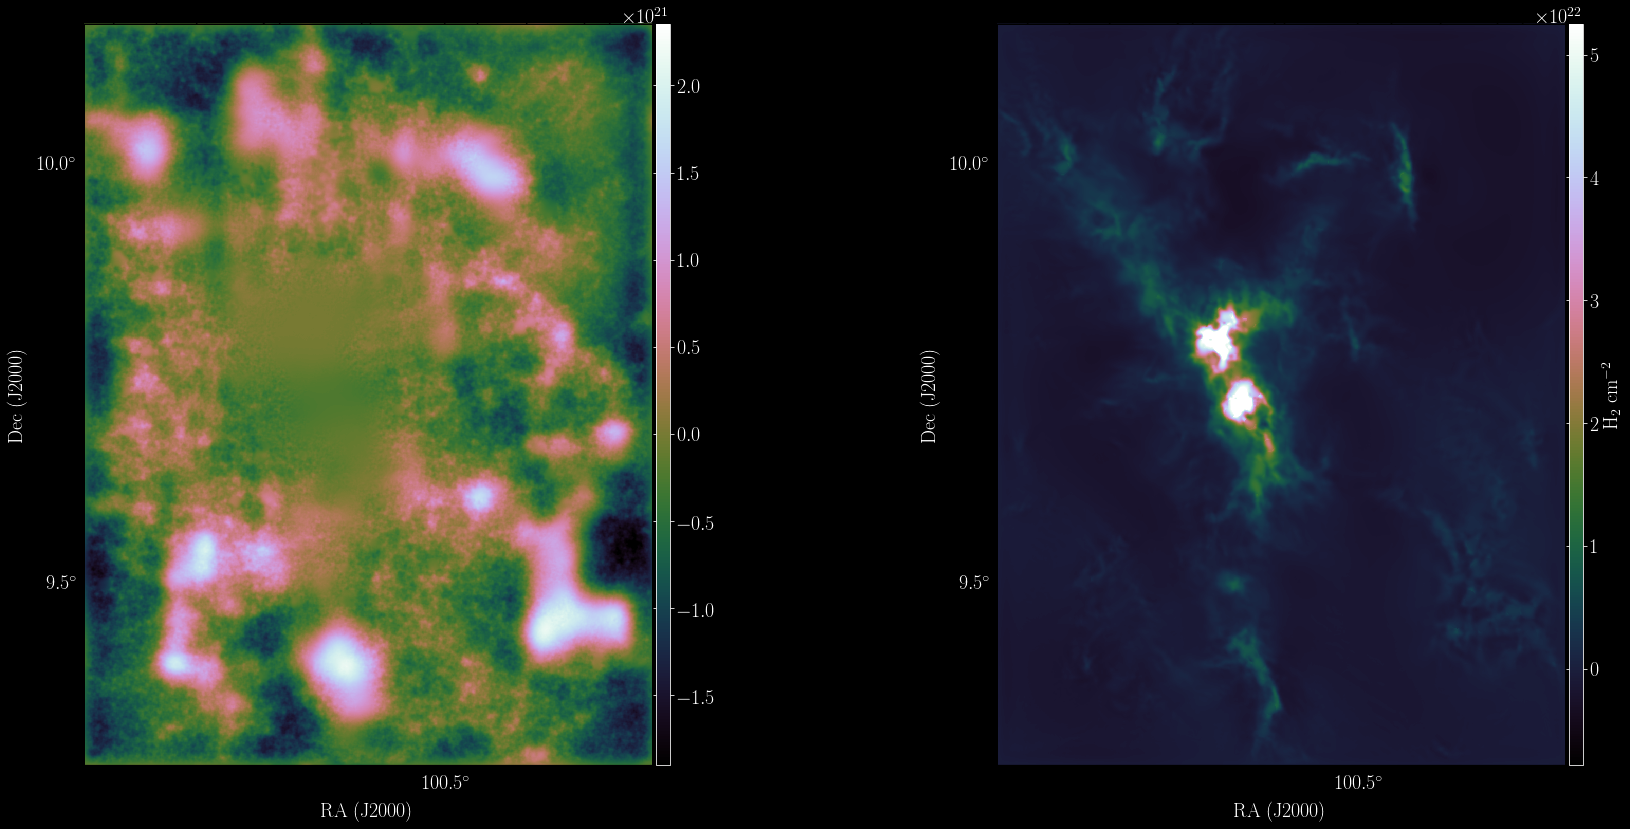

In [71]:
fig_all = plt.figure(1, figsize=(30,30))

figfile = '/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264_gaussianB.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 1))
fig.show_colorscale(cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()

figfile = '/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264_coheB.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 2))
fig.show_colorscale(cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

I think that it is much better. Now we have to interprete and understand all this. First interesting point is that the 'Y' shape of the molecular cloud is completely gone in the Gaussian part. The spatial correlation between both components is not as obvious as for Polaris. This could be associated to the evolutionary stage of the region.

The Gaussian spatial fluctions can be associated with non-compressive turbulence (according to Kolmogorov statistical description). In the global gravitational collapse scenario, the molecular cloud contraction begin with the first anitropies in the region. Those can be caused by turbulence intermittency, thermal instabilities, shocks, magnetic field, gravity and/or a non-linear combination of all these processes. We can imagine that for a region old enough, where these processes are dominating, the spatial correlation between both components becomes harder to establish... (first interpreatation)

The new segmented power spectra:

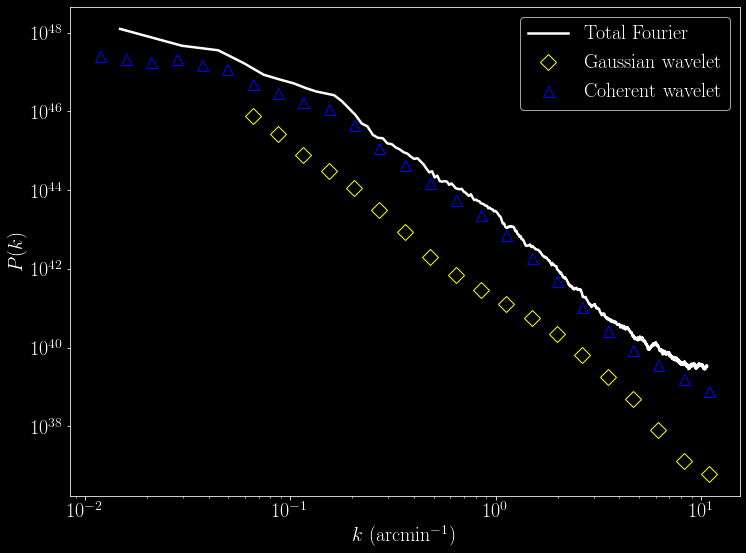

In [88]:
plt.figure(figsize(12,9))
plt.plot(tab_k, spec_k, color='white',label=r'Total Fourier')
plt.plot(wav_k[6:-1], S1a[2,6:-1],'D', markersize = 11, markerfacecolor='none', markeredgecolor='yellow', label='Gaussian wavelet')
plt.plot(wav_k[:-1], np.concatenate((S1a[0,0:6],S1a[1,6:-1])),'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Coherent wavelet')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

I still need to:
- Evaluate and correct for the noise and beam contribution
- It looks like the Cosmic Infrared Background is also contributing (as for Polaris) in this region
- Fit the power laws and compare the Gaussian component with Kolmogorov.